In [1]:
import pandas as pd
data = pd.read_csv('./class_pos_covid_scaled_minmax.csv')

In [2]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame

file_tag = "class_pos_covid"
target = "CovidPos"
labels: list = list(data[target].unique())
labels.sort()
print(f"Labels={labels}")

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == negative]),
        len(data[data[target] == positive]),
    ]
}

y: array = data.pop(target).to_list()
X: ndarray = data.values

Labels=[0, 1]


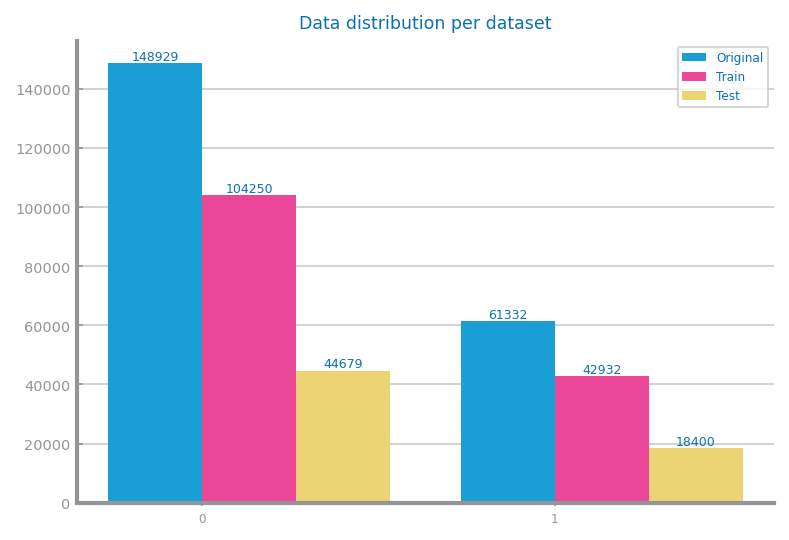

In [3]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from library.dslabs_functions import plot_multibar_chart


trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train: DataFrame = concat(
    [DataFrame(trnX, columns=data.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"./{file_tag}_train2.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"./{file_tag}_test2.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

In [4]:
from pandas import Series
#Balance the train df keep test df
target_count: Series = train[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

In [5]:
df_positives: Series = train[train[target] == positive_class]
df_negatives: Series = train[train[target] == negative_class]

In [6]:
from pandas import concat
# Balance and Save Train Set With OverSampling
df_pos_sample: DataFrame = DataFrame(df_positives.sample(len(df_negatives), replace=True))
train: DataFrame = concat([df_pos_sample, df_negatives], axis=0)

In [8]:
train.to_csv(f"./{file_tag}_train4.csv", index=False)

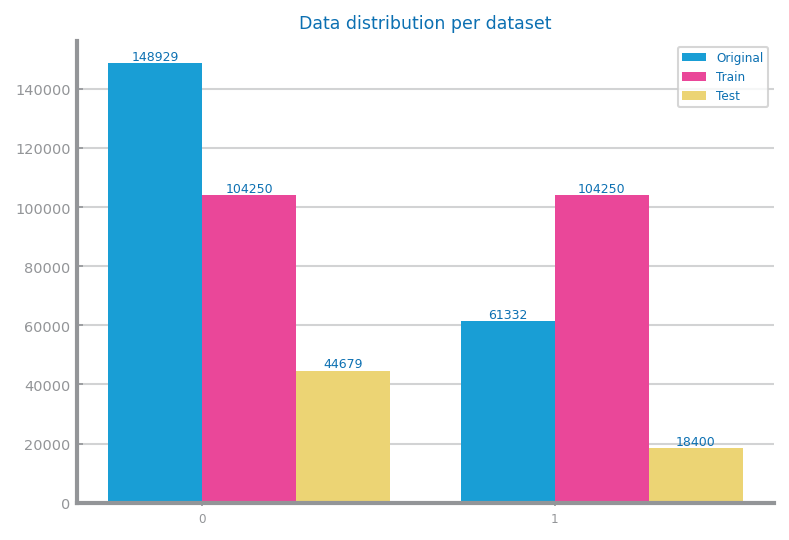

In [7]:
values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

In [2]:
from library.dslabs_functions import read_train_test_from_files

train_filename = "./class_pos_covid_train.csv"
test_filename = "./class_pos_covid_test.csv"
target = "CovidPos"
eval_metric = "accuracy"


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=147182 Test#=63079
Labels=[0, 1]


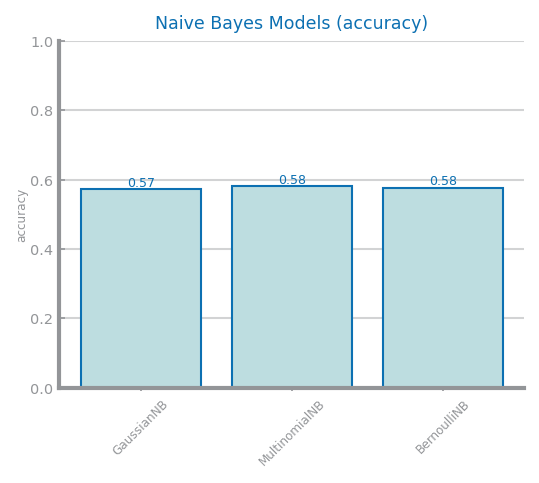

In [96]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from library.dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}_nb_{eval_metric}_study.png")
show()

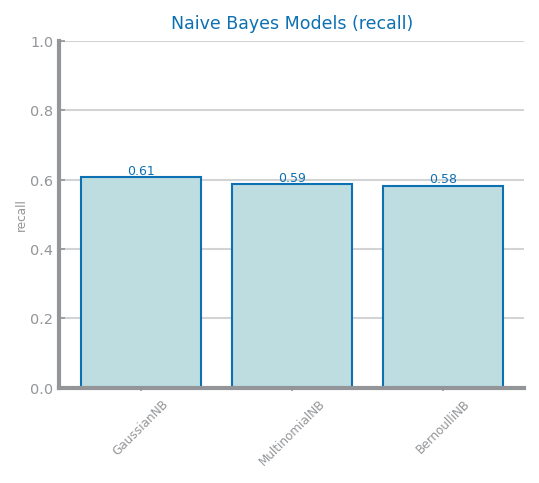

In [97]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"images/{file_tag}_nb_recall_study.png")
show()

<Figure size 600x450 with 0 Axes>

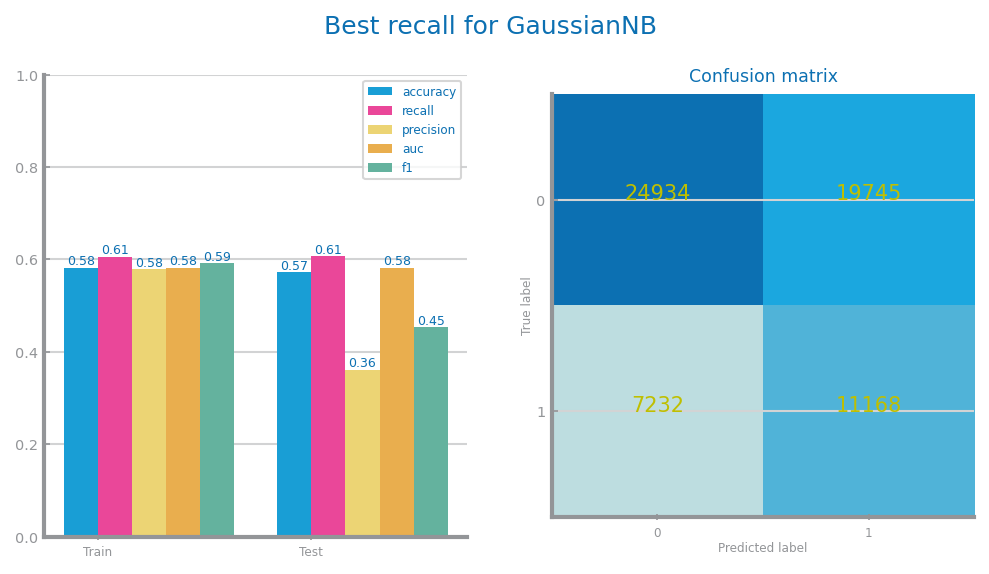

In [98]:
from library.dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_{params["name"]}_best_{params["metric"]}_eval.png')
show()

DT best with gini and d=24


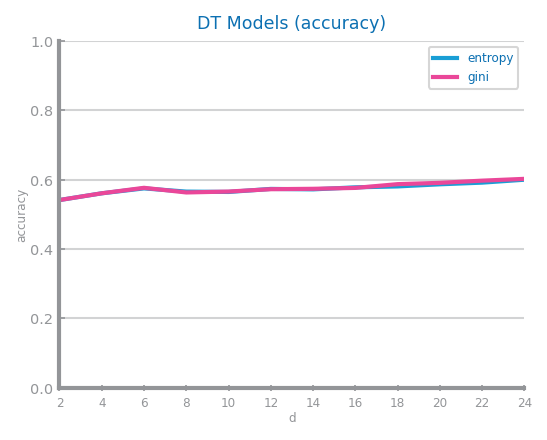

In [100]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from library.dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from library.dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

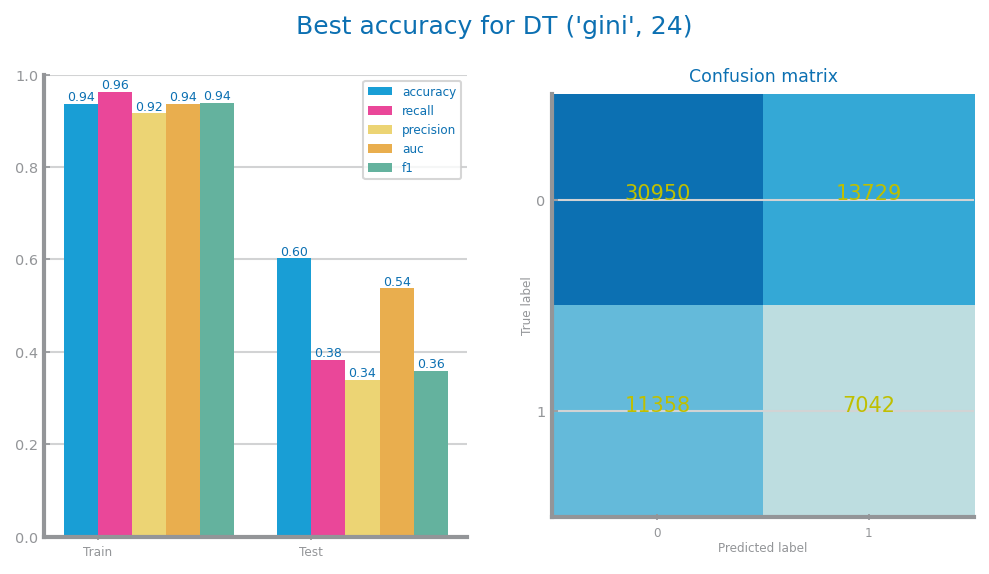

In [101]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

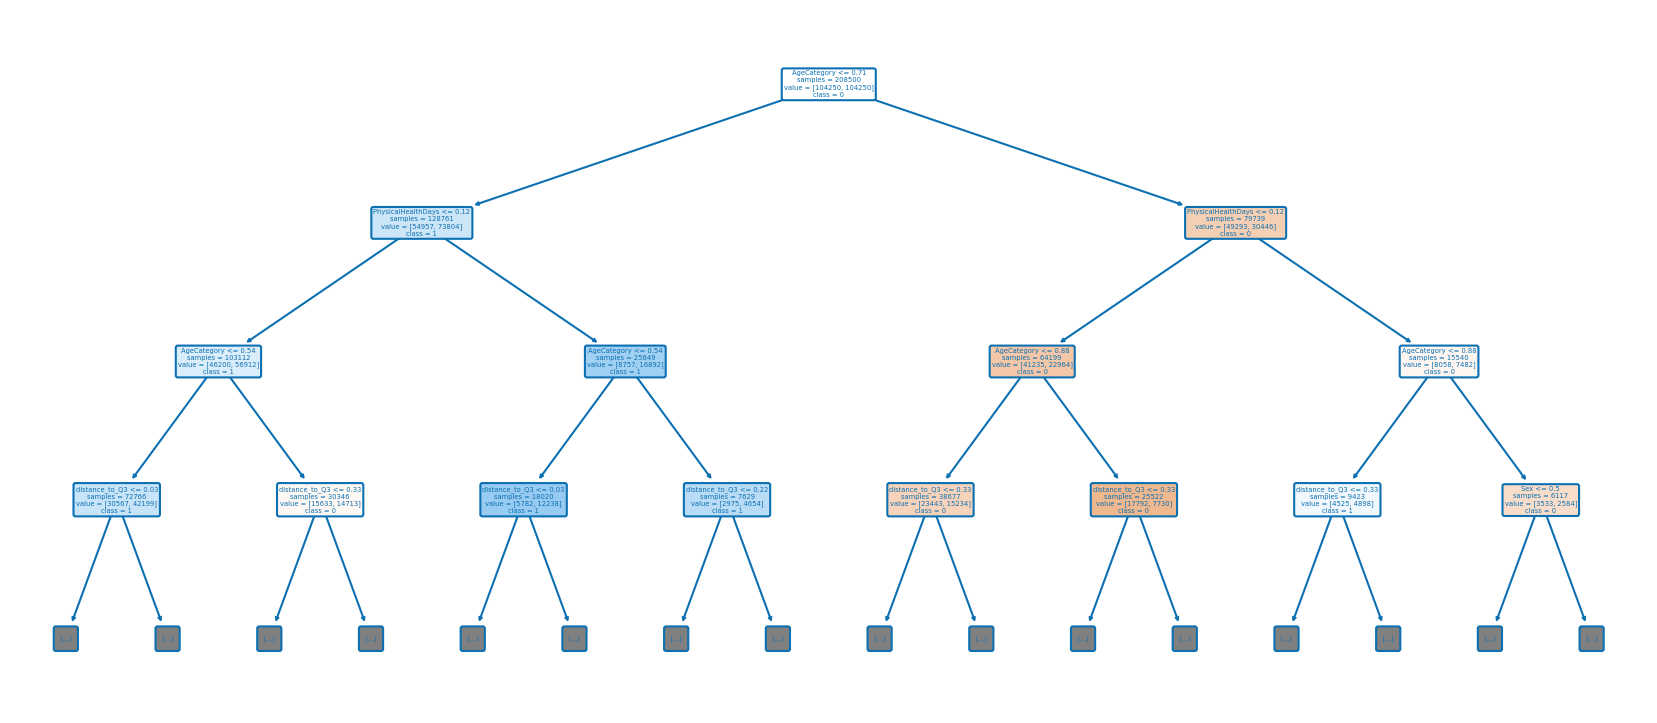

In [102]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png")

1. BMI (0.12394651975382388)
2. WeightInKilograms (0.08847672117176639)
3. AgeCategory (0.07642056386705777)
4. HeightInMeters (0.0594192416842033)
5. distance_to_Q3 (0.04734996424248289)
6. distance_to_Q1 (0.04058857121738253)
7. SleepHours (0.03799599334643912)
8. PhysicalHealthDays (0.03491152180033775)
9. MentalHealthDays (0.03419811503207784)
10. distance_to_Q4 (0.032751590972447606)
11. distance_to_Q2 (0.03249692775790386)
12. GeneralHealth (0.03237988019893284)
13. RemovedTeeth (0.022806332824324486)
14. SmokerStatus (0.017516885291695043)
15. HIVTesting (0.014110016361065333)
16. AlcoholDrinkers (0.013483448848723831)
17. PneumoVaxEver (0.01346297131175608)
18. HadArthritis (0.013189958807519197)
19. TetanusLast10Tdap_Yes, received Tdap (0.012330207894930468)
20. FluVaxLast12 (0.011714895332791945)
21. HadAsthma (0.011593445586431926)
22. TetanusLast10Tdap_Yes, received tetanus shot but not sure what type (0.011550842221714545)
23. TetanusLast10Tdap_No, did not receive any teta

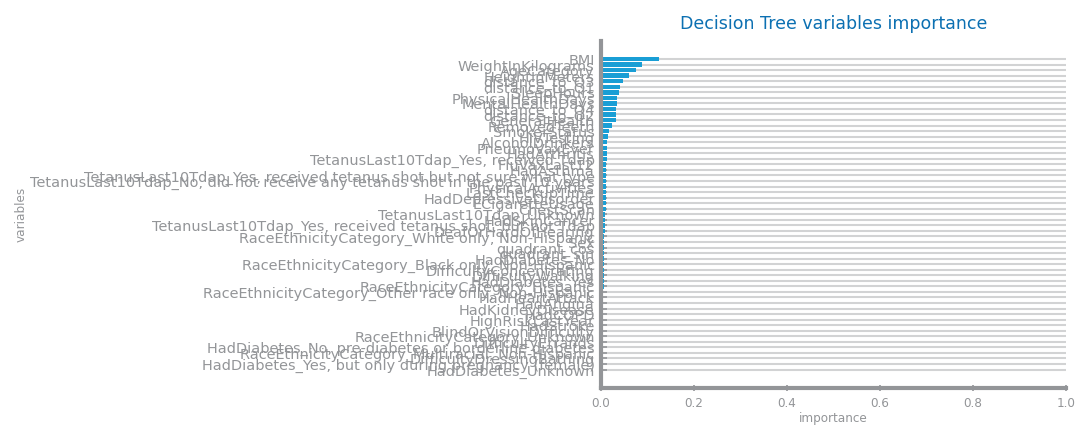

In [104]:
from numpy import argsort
from library.dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")

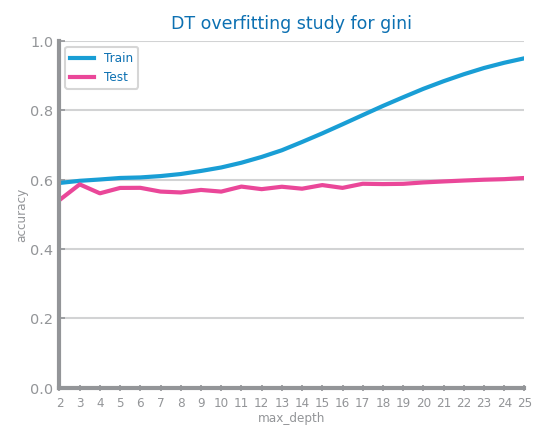

In [105]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

KNN manhattan k=1
KNN manhattan k=3
KNN manhattan k=5
KNN manhattan k=7
KNN euclidean k=1
KNN euclidean k=3
KNN euclidean k=5
KNN euclidean k=7
KNN chebyshev k=1
KNN chebyshev k=3
KNN chebyshev k=5
KNN chebyshev k=7
KNN best with k=1 and manhattan


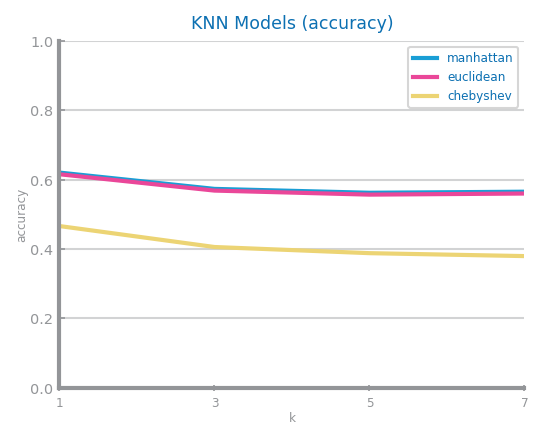

In [10]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from library.dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from library.dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f"KNN best with k={best_params['params'][0]} and {best_params['params'][1]}")
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=7, metric=eval_metric)
savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

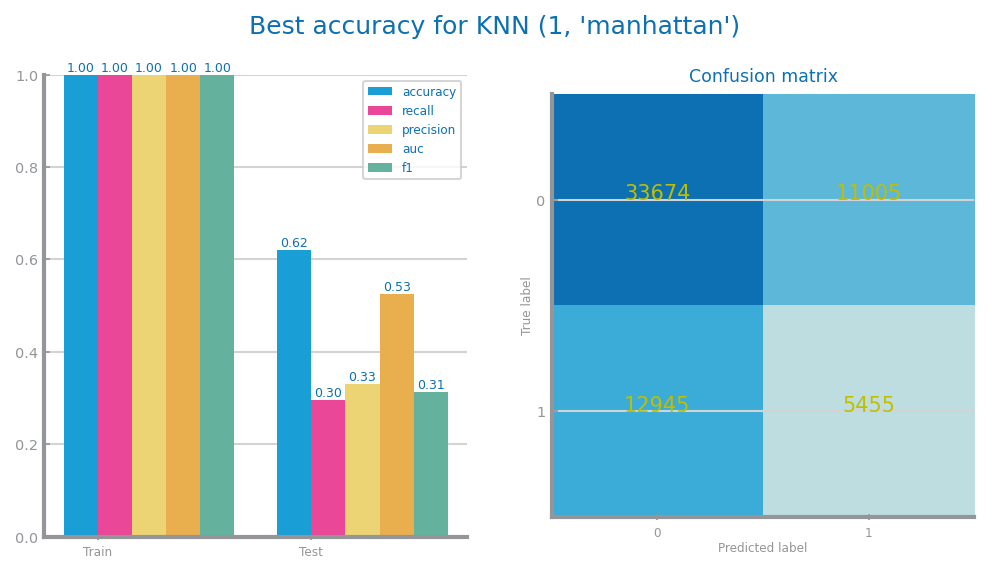

In [11]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_knn_{params["name"]}_best_{params["metric"]}_eval.png')
show()
44679


Current K: 1


------------------------------------------------------------
Current K: 3
------------------------------------------------------------
Current K: 5
------------------------------------------------------------
Current K: 7
------------------------------------------------------------
Current K: 9
------------------------------------------------------------
Current K: 11
------------------------------------------------------------
Current K: 13
------------------------------------------------------------
Current K: 15
------------------------------------------------------------
Current K: 17
------------------------------------------------------------
Current K: 19
------------------------------------------------------------
Current K: 21
------------------------------------------------------------
Current K: 23
------------------------------------------------------------


NameError: name 'file_tag' is not defined

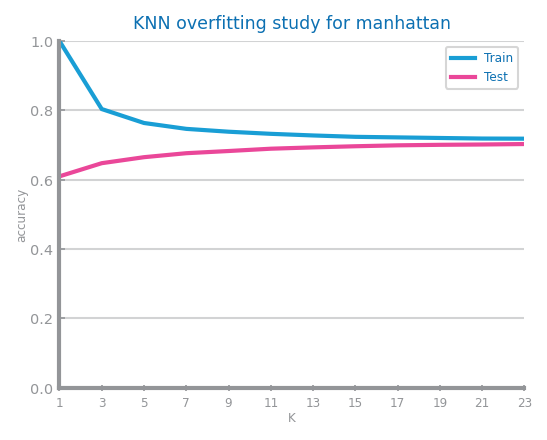

In [3]:
from matplotlib.pyplot import figure, savefig
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from library.dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from library.dslabs_functions import read_train_test_from_files, plot_evaluation_results

distance = "manhattan"
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    print("Current K:",k)
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    print("------------------------------------------------------------")

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()